# FlexFlow Co-Serving Demo


In [1]:
import json, random, subprocess, os
from datasets import load_dataset
from types import SimpleNamespace
from huggingface_hub import HfFolder
import flexflow.serve as ff
import matplotlib.pyplot as plt

%matplotlib inline

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def create_datasets(finetune_dataset_size=2, inference_file_path='inference_dataset.json', finetuning_file_path='finetuning_dataset.json'):
    """Creates the inference and finetuning datasets according to the data from https://huggingface.co/datasets/databricks/databricks-dolly-15k.
    Only the 'open_qa' and 'closed_qa' prompts without context are kept.
    The datasets are saved into the files given as arguments.

    Keyword arguments:
    dataset_size -- the number of prompts to consider
    inference_file_path -- the file in which to save the inference data
    finetuning_file_path -- the file in which to save the finetuning data
    """
    dataset = load_dataset("databricks/databricks-dolly-15k", split="train")
    inference_data = []
    finetuning_data = []
    for row in dataset:
        if len(finetuning_data) == finetune_dataset_size:
            break
        if ("open_qa" in row['category'] or "closed_qa" in row['category']) and len(row['context']) == 0:
            inference_data.append(row['instruction'])
            finetuning_data.append(row['instruction'] + " " + row['response'])
    with open(inference_file_path, 'w') as file:
        json.dump(inference_data[:1], file)
    with open(finetuning_file_path, 'w') as file:
        json.dump(finetuning_data[:1], file, indent=2, separators=(',', ': '))

## Configuration fields

In [3]:
configs_dict = {
    "num_gpus": 1,
    "memory_per_gpu": 21000,
    "zero_copy_memory_per_node": 40000,
    "num_cpus": 4,
    "legion_utility_processors": 4,
    "data_parallelism_degree": 1,
    "tensor_parallelism_degree": 1,
    "pipeline_parallelism_degree": 1,
    "offload": False,
    "offload_reserve_space_size": 8 * 1024,  # 8GB
    "use_4bit_quantization": False,
    "use_8bit_quantization": False,
    "enable_peft": True,
    "peft_activation_reserve_space_size": 1024,  # 1GB
    "peft_weight_reserve_space_size": 1024,  # 1GB
    "profiling": False,
    "inference_debugging": False,
    "fusion": False,
    "max_requests_per_batch": 1,
    "max_sequence_length": 128,
    "max_tokens_per_batch": 128,
    "max_training_steps": 100,
    "seed": 42,
}
model_configs = {
    "base_model": "meta-llama/Meta-Llama-3-8B",
    "inference_peft_model_id": "goliaro/llama-3-8b-lora",
    "finetuning_peft_model_id": "goliaro/llama-3-8b-lora",
    "cache_path": os.environ.get("FF_CACHE_PATH", ""),
    "refresh_cache": False,
    "full_precision": False,
    # relative paths
    "inference_dataset": "inference_dataset.json",
    "finetuning_dataset": "/usr/FlexFlow/inference/prompt/peft_dataset.json",
    "output_file": "peft_demo.txt",
}
generation_configs = {
    "do_sample": False,
    "temperature": 0.9,
    "topp": 0.8,
    "topk": 1,
}
finetuning_configs = {
    "learning_rate": 0.001,
    "momentum": 0.0,
    "weight_decay": 0.0,
    "nesterov": False,
}
# Merge dictionaries
configs_dict.update(model_configs)
configs_dict.update(generation_configs)
configs_dict.update(finetuning_configs)

In [4]:
random.seed(configs_dict["seed"])

configs = SimpleNamespace(**configs_dict)

create_datasets(inference_file_path=configs_dict["inference_dataset"], 
                finetuning_file_path=configs_dict["finetuning_dataset"])

# Clear output file
with open(configs.output_file, 'w') as file:
    file.write('')

## Download base and peft inference models

In [5]:
args = [configs.inference_peft_model_id, '--base_model_name', configs.base_model]
subprocess.run(['python', '../../utils/download_peft_model.py'] + args)

/opt/conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Creating directory /root/.cache/flexflow/configs/meta-llama/meta-llama-3-8b (if it doesn't exist)...
Saving meta-llama/Meta-Llama-3-8B configs to file /root/.cache/flexflow/configs/meta-llama/meta-llama-3-8b/config.json...
Saving goliaro/llama-3-8b-lora configs to file /root/.cache/flexflow/configs/goliaro/llama-3-8b-lora/config.json...
Loading tokenizer...
Creating directory /root/.cache/flexflow/configs/meta-llama/meta-llama-3-8b (if it doesn't exist)...
Saving meta-llama/Meta-Llama-3-8B configs to file /root/.cache/flexflow/configs/meta-llama/meta-llama-3-8b/config.json...
Saving goliaro/llama-3-8b-lora configs to file /root/.cache/flexflow/configs/goliaro/llama-3-8b-lora/config.json...
Loading tokenizer...


CompletedProcess(args=['python', '../../utils/download_peft_model.py', 'goliaro/llama-3-8b-lora', '--base_model_name', 'meta-llama/Meta-Llama-3-8B'], returncode=0)

## Initialize FlexFlow runtime and LLM object

In [6]:
# Initialize the FlexFlow runtime. ff.init() takes a dictionary or the path to a JSON file with the configs
ff.init(configs_dict)

# Create the FlexFlow LLM
ff_data_type = (
    ff.DataType.DT_FLOAT if configs.full_precision else ff.DataType.DT_HALF
)
llm = ff.LLM(
    configs.base_model,
    data_type=ff_data_type,
    cache_path=configs.cache_path,
    refresh_cache=configs.refresh_cache,
    output_file=configs.output_file,
)
# Add inference and/or finetuning lora
lora_inference_config = None
lora_finetuning_config = None
if len(configs.inference_dataset) > 0:
    lora_inference_config = ff.LoraLinearConfig(
        llm.cache_path, 
        configs.inference_peft_model_id,
        base_model_name_or_path=configs.base_model
    )
    llm.add_peft(lora_inference_config)
if len(configs.finetuning_dataset) > 0:
    lora_finetuning_config = ff.LoraLinearConfig(
        llm.cache_path,
        configs.finetuning_peft_model_id,
        trainable=True,
        init_lora_weights=False,
        rank=16,
        lora_alpha=16.0,
        # target_modules = ["down_proj"],
        base_model_name_or_path=configs.base_model,
        optimizer_type=ff.OptimizerType.OPTIMIZER_TYPE_SGD,
        optimizer_kwargs={
            "learning_rate": configs.learning_rate,
            "momentum": configs.momentum,
            "weight_decay": configs.weight_decay,
            "nesterov": configs.nesterov,
        },
    )
    llm.add_peft(lora_finetuning_config)

# Compile the LLM for inference and load the weights into memory
generation_config = ff.GenerationConfig(
    do_sample=configs.do_sample,
    temperature=configs.temperature,
    topp=configs.topp,
    topk=configs.topk
)
enable_peft_finetuning = len(configs.finetuning_dataset) > 0
llm.compile(
    generation_config,
    enable_peft_finetuning=enable_peft_finetuning,
    max_requests_per_batch=configs.max_requests_per_batch+int(enable_peft_finetuning),
    max_seq_length=configs.max_sequence_length,
    max_tokens_per_batch=configs.max_tokens_per_batch,
)

[0 - 7f4d49d21280]    0.672934 {3}{Mapper}: Enabled Control Replication Optimizations.
[0 - 7f4d49d21280]    0.672995 {3}{Mapper}: Enabled Control Replication Optimizations.
[0 - 7f4d49d21280]    0.673107 {3}{Mapper}: Enabled Control Replication Optimizations.
[0 - 7f4d49d21280]    0.673118 {3}{Mapper}: Enabled Control Replication Optimizations.
[0 - 7f4d49d21280]    0.673124 {3}{Mapper}: Enabled Control Replication Optimizations.
/opt/conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
workSpaceSize (128 MB)
Creating directory /root/.cache/flexflow/configs/meta-llama/meta-llama-3-8b (if it doesn't exist)...
Saving meta-llama/Meta-Llama-3-8B configs to file /root/.cache/flexflow/configs/meta-llama/meta-llama-3-8b/config.json...
Saving goliaro/llama-3-8b-lora conf

## Start the LLM Co-serving system

In [7]:
llm.start_server()

Background server started.
2024-07-22 06:45:43 - ###PEFT DEBUGGING### Starting background serving task.
2024-07-22 06:45:43 - ###PEFT DEBUGGING### Updated models' configuration.
###PEFT DEBUGGING### LLM Model object exists.
###PEFT DEBUGGING### Model object exists.
###PEFT DEBUGGING### Model object still exists.
###PEFT DEBUGGING### Entering compile_inference.
###PEFT DEBUGGING### Configuration check passed: At least four CPU cores per node.


## Generate inference

In [8]:
prompts = [s for s in json.load(open(configs.inference_dataset))]
inference_requests = [
    ff.Request(
        ff.RequestType.REQ_INFERENCE,
        prompt=prompt,
        max_sequence_length=configs.max_sequence_length,
        peft_model_id=llm.get_ff_peft_id(lora_inference_config),
    )
    for prompt in prompts
]
inf_req_res_1 = llm.generate(inference_requests)
with open("before_finetuning.txt", "w") as file:
    file.write(str(inf_req_res_1[0].output_text))

###PEFT DEBUGGING### Launching graph optimization task.
num_nodes = 1 num_gpus_per_node = 1
[0]10445
[1]649
[2]6730
[3]2053
[4]18167
[5]369
[6]1317
[7]2085
[8]3090
[9]30
No small speculative model registered, using incremental decoding.
[0 - 7f4d49d21280]    1.600215 {3}{RequestManager}: [1000000]New request tokens: 128000 10445 649 6730 2053 18167 369 1317 2085 3090 30
optimal_views.size = 262
views.size() = 262
###PEFT DEBUGGING### Operators reconstructed from optimized graph.
###PEFT DEBUGGING### Starting inplace optimizations.
###PEFT DEBUGGING### Mapping output tensors.
ndim(1) dims[1 0 0 0]
###PEFT DEBUGGING### Setting up NCCL communications.
###PEFT DEBUGGING### compile_inference completed successfully.
Loading weight file embed_tokens.weight
Loading weight file layers.0.input_layernorm.weight
Loading weight file layers.0.self_attn.q_proj.weight
Loading weight file layers.0.self_attn.k_proj.weight
Loading weight file layers.0.self_attn.v_proj.weight
Loading weight file layers.0.

## Perform Finetuning on dataset

In [9]:
finetuning_request = ff.Request(
    ff.RequestType.REQ_FINETUNING,
    max_sequence_length=configs.max_sequence_length,
    peft_model_id=llm.get_ff_peft_id(lora_finetuning_config),
    dataset_filepath=os.path.join(os.getcwd(), configs.finetuning_dataset),
    max_training_steps=configs.max_training_steps,
)
ft_res = llm.generate([finetuning_request])

No small speculative model registered, using incremental decoding.
[0 - 7f4d49d21280]   29.957050 {3}{RequestManager}: [0] input: 128000 10445 649 6730 2053 18167 369 1317 2085 3090 30 8215 2053 1005 279 8834 304 872 305 12055 311 2567 1124 10409 449 4907 323 88000 369 1317 18852 315 892 13
[0 - 7f4d49d21280]   29.957061 {3}{RequestManager}: [0] output:
Loss: 2.6536
Loss: 2.5942
Loss: 2.5360
Loss: 2.5083
Loss: 2.4783
Loss: 2.4570
Loss: 2.4420
Loss: 2.4194
Loss: 2.4050
Loss: 2.3949
Loss: 2.3841
Loss: 2.3764
Loss: 2.3676
Loss: 2.3535
Loss: 2.3396
Loss: 2.3299
Loss: 2.3287
Loss: 2.3215
Loss: 2.3058
Loss: 2.2978
Loss: 2.2885
Loss: 2.2852
Loss: 2.2660
Loss: 2.2619
Loss: 2.2594
Loss: 2.2479
Loss: 2.2379
Loss: 2.2243
Loss: 2.2245
Loss: 2.2057
Loss: 2.2035
Loss: 2.1891
Loss: 2.1817
Loss: 2.1703
Loss: 2.1592
Loss: 2.1548
Loss: 2.1383
Loss: 2.1321
Loss: 2.1179
Loss: 2.1138
Loss: 2.1062
Loss: 2.0934
Loss: 2.0856
Loss: 2.0758
Loss: 2.0656
Loss: 2.0532
Loss: 2.0497
Loss: 2.0410
Loss: 2.0258
Loss: 2

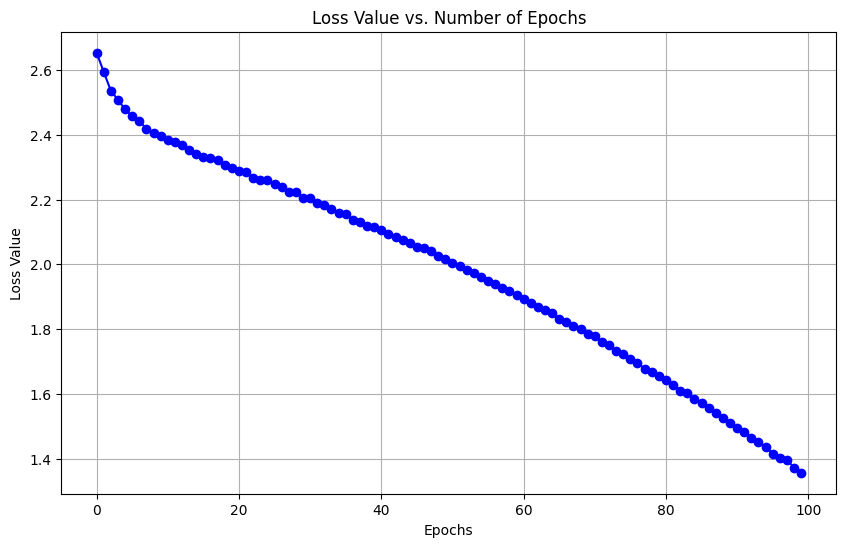

In [10]:
epochs = list(range(configs_dict["max_training_steps"]))
loss_values = ft_res[0].finetuning_losses

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b')

# Set plot labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.title('Loss Value vs. Number of Epochs')

plt.grid(True)
plt.show()

## Save finetuned model to HuggingFace

In [ ]:
subprocess.run(['python', '../../utils/upload_peft_model.py'] + f"--peft-model-id {configs.finetuning_peft_model_id} --upload-peft-model-id {configs.finetuning_peft_model_id}-dolly".split())


## Stop LLM Co-serving system

In [11]:
llm.stop_server()

2024-07-22 06:46:20 - ###PEFT DEBUGGING### Background serving task completed.
Background server stopped.


## Inference all over again with the finetuned model

In [1]:
import json, random, subprocess, os
from datasets import load_dataset
from types import SimpleNamespace
from huggingface_hub import HfFolder
import flexflow.serve as ff
import matplotlib.pyplot as plt

configs_dict = {
    "num_gpus": 1,
    "memory_per_gpu": 21000,
    "zero_copy_memory_per_node": 40000,
    "num_cpus": 4,
    "legion_utility_processors": 4,
    "data_parallelism_degree": 1,
    "tensor_parallelism_degree": 1,
    "pipeline_parallelism_degree": 1,
    "offload": False,
    "offload_reserve_space_size": 8 * 1024,  # 8GB
    "use_4bit_quantization": False,
    "use_8bit_quantization": False,
    "enable_peft": True,
    "peft_activation_reserve_space_size": 1024,  # 1GB
    "peft_weight_reserve_space_size": 1024,  # 1GB
    "profiling": False,
    "inference_debugging": False,
    "fusion": False,
    "max_requests_per_batch": 1,
    "max_sequence_length": 128,
    "max_tokens_per_batch": 128,
    "max_training_steps": 100,
    "seed": 42,
}
model_configs = {
    "base_model": "meta-llama/Meta-Llama-3-8B",
    "inference_peft_model_id": "goliaro/llama-3-8b-lora",
    "finetuning_peft_model_id": "goliaro/llama-3-8b-lora",
    "cache_path": os.environ.get("FF_CACHE_PATH", ""),
    "refresh_cache": False,
    "full_precision": False,
    # relative paths
    "inference_dataset": "inference_dataset.json",
    "finetuning_dataset": "/usr/FlexFlow/inference/prompt/peft_dataset.json",
    "output_file": "peft_demo.txt",
}
generation_configs = {
    "do_sample": False,
    "temperature": 0.9,
    "topp": 0.8,
    "topk": 1,
}
finetuning_configs = {
    "learning_rate": 0.001,
    "momentum": 0.0,
    "weight_decay": 0.0,
    "nesterov": False,
}
# Merge dictionaries
configs_dict.update(model_configs)
configs_dict.update(generation_configs)
configs_dict.update(finetuning_configs)

configs = SimpleNamespace(**configs_dict)


args = [configs.finetuning_peft_model_id+"-dolly", '--base_model_name', configs.base_model]
subprocess.run(['python', '../../utils/download_peft_model.py'] + args)

# Initialize the FlexFlow runtime. ff.init() takes a dictionary or the path to a JSON file with the configs
ff.init(configs_dict)

# Create the FlexFlow LLM
ff_data_type = (
    ff.DataType.DT_FLOAT if configs.full_precision else ff.DataType.DT_HALF
)
llm = ff.LLM(
    configs.base_model,
    data_type=ff_data_type,
    cache_path=configs.cache_path,
    refresh_cache=configs.refresh_cache,
    output_file=configs.output_file,
)

lora_inference_config2 = ff.LoraLinearConfig(
    llm.cache_path, 
    configs.finetuning_peft_model_id+"-dolly",
    base_model_name_or_path=configs.base_model
)
llm.add_peft(lora_inference_config2)


# Compile the LLM for inference and load the weights into memory
generation_config = ff.GenerationConfig(
    do_sample=configs.do_sample,
    temperature=configs.temperature,
    topp=configs.topp,
    topk=configs.topk
)
llm.compile(
    generation_config,
    max_requests_per_batch=configs.max_requests_per_batch,
    max_seq_length=configs.max_sequence_length,
    max_tokens_per_batch=configs.max_tokens_per_batch,
)

llm.start_server()

prompts = [s for s in json.load(open(configs.inference_dataset))]
inference_requests = [
    ff.Request(
        ff.RequestType.REQ_INFERENCE,
        prompt=prompt,
        max_sequence_length=configs.max_sequence_length,
        peft_model_id=llm.get_ff_peft_id(lora_inference_config2),
    )
    for prompt in prompts
]
inf_req_res_2 = llm.generate(inference_requests)

llm.stop_server()

with open("after_finetuning.txt", "w") as file:
    file.write(str(inf_req_res_2[0].output_text))

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Creating directory /root/.cache/flexflow/configs/meta-llama/meta-llama-3-8b (if it doesn't exist)...
Saving meta-llama/Meta-Llama-3-8B configs to file /root/.cache/flexflow/configs/meta-llama/meta-llama-3-8b/config.json...
Saving goliaro/llama-3-8b-lora-dolly configs to file /root/.cache/flexflow/configs/goliaro/llama-3-8b-lora-dolly/config.json...
Loading tokenizer...
Creating directory /root/.cache/flexflow/configs/meta-llama/meta-llama-3-8b (if it doesn't exist)...
Saving meta-llama/Meta-Llama-3-8B configs to file /root/.cache/flexflow/configs/meta-llama/meta-llama-3-8b/config.json...
Saving goliaro/llama-3-8b-lora-dolly configs to file /root/.cache/flexflow/configs/goliaro/llama-3-8b-lora-dolly/config.json...
Loading tokenizer...
[0 - 7ff1caf83280]    0.270628 {3}{Mapper}: Enabled Control Replication Optimizations.
[0 - 7ff1caf83280]    0.270673 {3}{Mapper}: Enabled Control Replication Optimizations.
[0 - 7ff1caf83280]    0.270699 {3}{Mapper}: Enabled Control Replication Optimizati